In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from scipy.stats import randint
import joblib
from sklearn.ensemble import RandomForestRegressor

In [2]:
cod = pd.read_csv("cod.csv")
cod = cod.drop('name', axis=1)
print(cod.head())
print(cod.shape)

   wins  kills  kdRatio  killstreak  level  losses  prestige  hits  \
0     0      0  0.00000           0      1       0         0     0   
1     0      0  0.00000           0      1       0       110     0   
2     0     66  1.03125           0      9       0       110     0   
3     3      2  0.40000           0      1       0         0     0   
4     0      2  0.20000           0      1       0       110     0   

   timePlayed  headshots  averageTime  gamesPlayed  assists  misses     xp  \
0           0          0          0.0            0        0       0      0   
1           7          0          7.0            0        0       0    700   
2          32         16         32.0            0        1       0  48300   
3           3          0          3.0            0        0       0   1150   
4           5          1          5.0            0        0       0   1000   

   scorePerMinute  shots  deaths  
0             0.0      0       0  
1             0.0      0      16  
2    

In [3]:
print(cod.describe())

              wins         kills      kdRatio   killstreak        level  \
count  1558.000000   1558.000000  1558.000000  1558.000000  1558.000000   
mean    153.002567   3753.001926     0.637098     6.895379    44.414634   
std     301.984766   7929.696675     0.430459    10.184677    68.318064   
min       0.000000      0.000000     0.000000     0.000000     1.000000   
25%       0.000000      4.000000     0.261442     0.000000     1.000000   
50%      10.000000    191.500000     0.732837     5.000000    11.000000   
75%     168.000000   3445.750000     0.955293    12.000000    51.000000   
max    3519.000000  66935.000000     3.000000   235.000000   435.000000   

            losses     prestige           hits   timePlayed     headshots  \
count  1558.000000  1558.000000    1558.000000  1558.000000   1558.000000   
mean      4.998074    47.657253   10330.189987   425.915918    630.672657   
std       7.005778    51.626213   22954.104384   786.182499   1305.150393   
min       0.0000

In [4]:
# Calculate Accuracy by dividing hits by shots, handling division by zero
mask = cod['shots'] != 0  # Create a mask for non-zero shots
cod.loc[mask, 'Accuracy'] = cod['hits'] / cod['shots']
cod.loc[~mask, 'Accuracy'] = pd.NA  # Set Accuracy to pd.NA for zero shots

# Calculate Headshot Ratio by dividing headshots by kills, handling division by zero
mask = cod['kills'] != 0  # Create a mask for non-zero shots
cod.loc[mask, 'Headshot Ratio'] = cod['headshots'] / cod['kills']
cod.loc[~mask, 'Headshot Ratio'] = pd.NA  # Set Accuracy to pd.NA for zero shots

print(cod.columns)

Index(['wins', 'kills', 'kdRatio', 'killstreak', 'level', 'losses', 'prestige',
       'hits', 'timePlayed', 'headshots', 'averageTime', 'gamesPlayed',
       'assists', 'misses', 'xp', 'scorePerMinute', 'shots', 'deaths',
       'Accuracy', 'Headshot Ratio'],
      dtype='object')


RANDOM FOREST ROUND 1

In [5]:
X = cod.drop('wins', axis=1)
y = cod['wins']

# Calculate the first quartile (Q1) and third quartile (Q3)
Q1 = cod['gamesPlayed'].quantile(0.25)
Q3 = cod['gamesPlayed'].quantile(0.75)

# Calculate the IQR (Interquartile Range)
IQR = Q3 - Q1

# Define the upper and lower bounds to identify outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out rows where data points are outside the bounds
cod = cod[(cod['gamesPlayed'] >= lower_bound) & (cod['gamesPlayed'] <= upper_bound)]
cod = cod[cod['gamesPlayed'] != 0]

In [6]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 

In [7]:
# Update the pipeline to use RandomForestRegressor
rf_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('poly', PolynomialFeatures(degree=1, include_bias=False)),
    ('standard', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=0))
])

In [10]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import randint
import numpy as np

# Assuming 'cod' is your DataFrame and the necessary imports and initial processing are already done.

# Set up your feature matrix and target vector
X = cod.drop('wins', axis=1)
y = cod['wins']

# Filtering out outliers and zero gamesPlayed as already defined in your code
Q1 = cod['gamesPlayed'].quantile(0.25)
Q3 = cod['gamesPlayed'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
cod_filtered = cod[(cod['gamesPlayed'] >= lower_bound) & (cod['gamesPlayed'] <= upper_bound) & (cod['gamesPlayed'] != 0)]

X = cod_filtered.drop('wins', axis=1)
y = cod_filtered['wins']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Define the pipeline
rf_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('poly', PolynomialFeatures(degree=1, include_bias=False)),
    ('standard', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=0))
])

# Define the parameter space for RandomizedSearchCV
param_distributions = {
    'rf__n_estimators': randint(100, 300),
    'rf__max_depth': randint(3, 10),  # Reduced depth
    'rf__min_samples_leaf': randint(6, 20),  # Increased samples per leaf
    'rf__min_samples_split': randint(15, 30),  # Increased samples needed to split
    'rf__max_features': ['sqrt', 'log2'],
}


# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    rf_pipe,
    param_distributions=param_distributions,
    n_iter=20,  # Number of parameter settings that are sampled
    cv=10,  # Number of folds in cross-validation
    scoring='neg_mean_squared_error',
    random_state=102,
    verbose=1
)

# Fit the model
random_search.fit(X_train, y_train)

# Predict on the training set and testing set
y_train_pred = random_search.predict(X_train)
y_test_pred = random_search.predict(X_test)

# Calculate RMSE for training and testing sets
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Output the results
print("Training RMSE: {:.2f}".format(train_rmse))
print("Testing RMSE: {:.2f}".format(test_rmse))

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Training RMSE: 59.36
Testing RMSE: 78.64


Log Transformed Random Forest

In [11]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import FunctionTransformer
from scipy.stats import randint
import numpy as np

# Assuming 'cod' is your DataFrame and the necessary imports and initial processing are already done.

# Set up your feature matrix and target vector
X = cod.drop('wins', axis=1)
y = cod['wins']

# Filtering out outliers and zero gamesPlayed as already defined in your code
Q1 = cod['gamesPlayed'].quantile(0.25)
Q3 = cod['gamesPlayed'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
cod_filtered = cod[(cod['gamesPlayed'] >= lower_bound) & (cod['gamesPlayed'] <= upper_bound) & (cod['gamesPlayed'] != 0)]

X = cod_filtered.drop('wins', axis=1)
y = cod_filtered['wins']

# Transform the target variable 'wins'
log_transformer = FunctionTransformer(np.log1p, inverse_func=np.expm1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Define the pipeline
rf_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('poly', PolynomialFeatures(degree=1, include_bias=False)),
    ('standard', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=0))
])

# Define the parameter space for RandomizedSearchCV
param_distributions = {
    'rf__n_estimators': randint(150, 500),
    'rf__max_depth': randint(5, 15),
    'rf__min_samples_leaf': randint(4, 12),
    'rf__min_samples_split': randint(10, 20),
    'rf__max_features': ['sqrt', 'log2'],
}

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    rf_pipe,
    param_distributions=param_distributions,
    n_iter=20,  # Number of parameter settings that are sampled
    cv=10,  # Number of folds in cross-validation
    scoring='neg_mean_squared_error',
    random_state=102,
    verbose=1
)

# Setup TransformedTargetRegressor with log transformation
tt_regressor = TransformedTargetRegressor(regressor=random_search, transformer=log_transformer)

# Fit the model
tt_regressor.fit(X_train, y_train)

# Predict on the training set and testing set
y_train_pred = tt_regressor.predict(X_train)
y_test_pred = tt_regressor.predict(X_test)

# Calculate RMSE for training and testing sets
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Output the results
print("Training RMSE: {:.2f}".format(train_rmse))
print("Testing RMSE: {:.2f}".format(test_rmse))


Fitting 10 folds for each of 20 candidates, totalling 200 fits
Training RMSE: 61.54
Testing RMSE: 81.04


Clustering

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# Create an imputer object with a median filling strategy
imputer = SimpleImputer(strategy='median')

# Apply the imputer to the data
cod_imputed = imputer.fit_transform(cod_filtered)

# Now scale the imputed data
scaler = StandardScaler()
cod_scaled = scaler.fit_transform(cod_imputed)

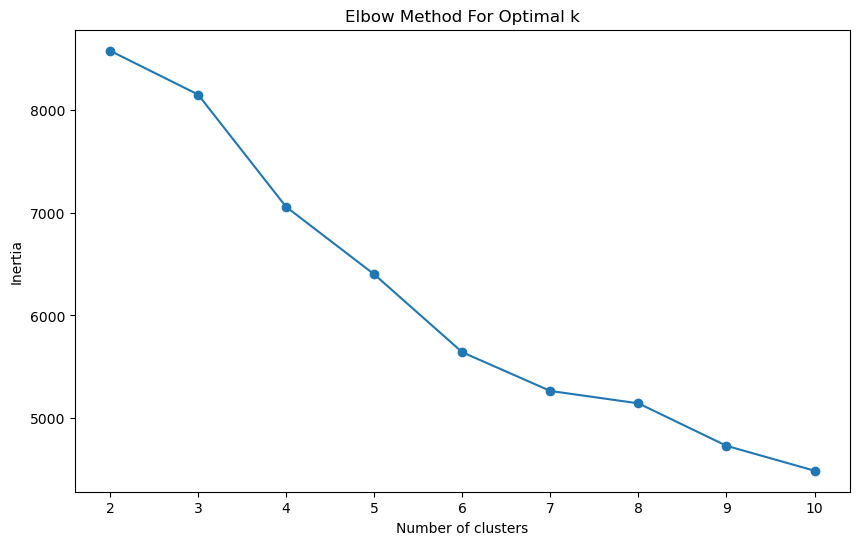

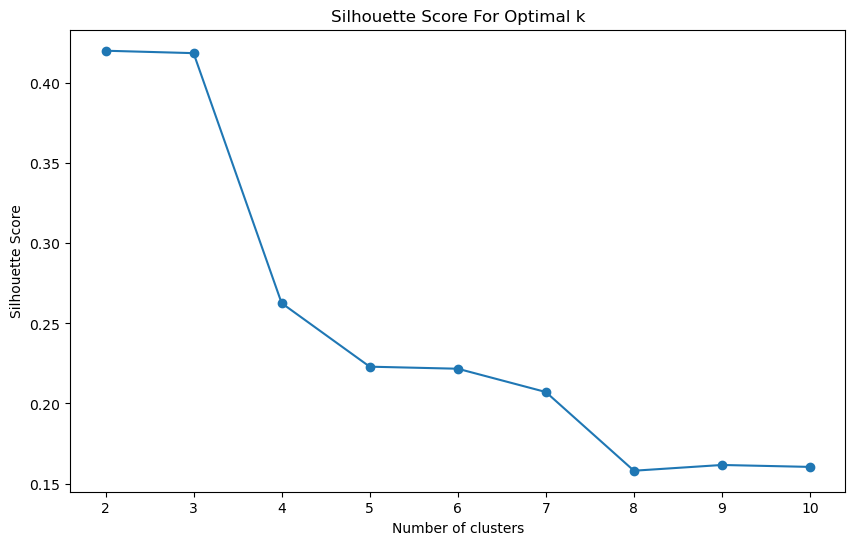

In [15]:
# Proceed with the Elbow Method and Silhouette Scores using cod_scaled
inertias = []
silhouette_scores = []
range_clusters = range(2, 11)

for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(cod_scaled)
    inertias.append(kmeans.inertia_)
    # Computing silhouette score can be expensive for large datasets, consider commenting this out if not needed
    silhouette_scores.append(silhouette_score(cod_scaled, kmeans.labels_))

# Plotting the Elbow Plot
plt.figure(figsize=(10, 6))
plt.plot(range_clusters, inertias, '-o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

# Plotting the Silhouette Scores for comparison
plt.figure(figsize=(10, 6))
plt.plot(range_clusters, silhouette_scores, '-o')
plt.title('Silhouette Score For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()



In [18]:
# Determine the optimal number of clusters based on the Elbow method and Silhouette score
k_optimal = 4 

# Apply K-means with the optimal number of clusters
kmeans_final = KMeans(n_clusters=k_optimal, random_state=0)
clusters = kmeans_final.fit_predict(cod_scaled)

# Add the cluster labels to the DataFrame for analysis
cod_filtered['Cluster'] = clusters

# Analyze the clusters by looking at the mean values of features in each cluster
cluster_means = cod_filtered.groupby('Cluster').mean()

# Print the cluster medians for interpretation
print(cluster_means)
#cluster_means.to_csv('cluster_means.csv')

               wins        kills   kdRatio  killstreak       level     losses  \
Cluster                                                                         
0         30.245509   478.565868  0.709262    7.107784   11.727545   4.029940   
1        395.793103  9112.706897  1.030690   17.413793  173.206897  10.000000   
2        211.977444  4828.827068  0.960433   13.375940   55.744361  10.563910   
3        103.956790  1654.907407  0.928659    9.549383   51.820988   5.518519   

           prestige          hits   timePlayed    headshots  averageTime  \
Cluster                                                                    
0         14.500000   1635.416168    64.781437    80.613772     6.559542   
1        100.241379  18926.896552  1542.103448  1750.241379    12.748975   
2         62.082707  16133.090226   490.932331   829.736842     3.152524   
3         99.401235   3139.833333   418.604938   312.388889    47.343636   

         gamesPlayed      assists        misses         

/var/folders/sx/239lgvxx1yn2qrq3szxf8q380000gn/T/ipykernel_83517/1475320479.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cod_filtered['Cluster'] = clusters


Player Behaviors Clustering

In [29]:
# Selecting features relevant to play styles
features = ['kills', 'deaths', 'scorePerMinute', 'headshots', 'assists', 'Accuracy', 'Headshot Ratio']
# Make a copy to avoid setting-with-copy warning
cod_play_styles = cod[features].copy()

# Preprocess the data
imputer = SimpleImputer(strategy='median')
cod_play_styles_imputed = imputer.fit_transform(cod_play_styles)
scaler = StandardScaler()
cod_play_styles_scaled = scaler.fit_transform(cod_play_styles_imputed)

# Apply clustering
kmeans = KMeans(n_clusters = 3, random_state = 0)
# Directly assigning the cluster labels to the DataFrame copy
cod_play_styles['Cluster'] = kmeans.fit_predict(cod_play_styles_scaled)

# Analyze the resulting clusters
cluster_means_style = cod_play_styles.groupby('Cluster').median()
print(cluster_means_style)
#cluster_means_style.to_csv('cluster_means_play_style.csv')


                kills        deaths  scorePerMinute    headshots      assists  \
Cluster                                                                         
0          390.304545    443.965909       17.087374    74.194318    59.122727   
1        26316.790323  26078.766129      200.692465  4270.782258  4904.830645   
2         4044.092058   4356.341155      231.293998   699.855596   736.904332   

         Accuracy  Headshot Ratio  
Cluster                            
0        0.158698        0.189185  
1        0.194591        0.164920  
2        0.173262        0.171759  
